# CTGAN in ABCD ASD
* Model Paper: Lei Xu, Maria Skoularidou, Alfredo Cuesta-Infante, Kalyan Veeramachaneni. Modeling Tabular data using Conditional GAN. NeurIPS, 2019.
* CTGAN 0.2.2.dev1documentation: https://sdv.dev/CTGAN/

## 0. load modules

In [1]:
### git clone
!git clone https://github.com/sdv-dev/SDV.git

fatal: destination path 'SDV' already exists and is not an empty directory.


In [76]:
### import module

## sys
import os
import sys
sys.path.append("/home/ubuntu/anaconda3/lib/python3.6/site-packages")
sys.path.append("/home/ubuntu/anaconda3/lib/python3.6/site-packages/ctgan-0.2.2.dev2-py3.6.egg")

## basic module
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from tqdm.notebook import tqdm
from pathlib import Path

## sdv
from sdmetrics import evaluate
from ctgan import CTGANSynthesizer
from sdv import load_demo, SDV, Metadata
from sdv.evaluation import evaluate

## sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import KFold

## torch
import torch
from torch import nn
from torch import tensor 
from torch.autograd import Variable
from pytorch_tabnet.tab_model import TabNetClassifier,TabNetRegressor

In [3]:
pwd

'/home/ubuntu/Betty/CTGAN'

## 1. prepare the data

In [77]:
### load data
dataset_name = 'mor.symp.demo.qc.z'
train_out = Path(os.getcwd()+ "/train_mor.symp.demo.qc.z.csv")
test_out = Path(os.getcwd()+ "/test_mor.symp.demo.qc.z.csv")
total_out = Path(os.getcwd()+ "/mor.symp.demo.qc.z.csv")

train_data = pd.read_csv(train_out)
test_data = pd.read_csv(test_out)
total_data = pd.read_csv(total_out)

In [ ]:
test_data.head()

In [78]:
### [TRAIN] check the data
nan_values = train_data.isna()
nan_bool = nan_values.any()
nan_columns = train_data.columns[nan_bool].tolist()
train_data.drop(nan_columns, inplace = True, axis=1)
train_data_keys = train_data.keys()
    
### [TEST] check the data
nan_values = test_data.isna()
nan_bool = nan_values.any()
nan_columns = test_data.columns[nan_bool].tolist()
test_data.drop(nan_columns, inplace = True, axis=1)
test_data_keys = test_data.keys()

In [79]:
### check the data structure again
#test_data.shape
#test_data.head()
#print(len(train_data), len(train_data.columns))
train_data_keys

Index(['subjectkey', 'age', 'abcd_site', 'ASD', 'dl_speech',
       'lh_bankssts_area._.1', 'lh_caudalanteriorcingulate_area._.1',
       'lh_caudalmiddlefrontal_area._.1', 'lh_cuneus_area._.1',
       'lh_entorhinal_area._.1',
       ...
       'wm.rh.supramarginal._.18', 'wm.rh.frontalpole._.18',
       'wm.rh.temporalpole._.18', 'wm.rh.transversetemporal._.18',
       'wm.rh.insula._.18', 'Left.UnsegmentedWhiteMatter._.18',
       'Right.UnsegmentedWhiteMatter._.18', 'lhCerebralWhiteMatterVol._.18',
       'rhCerebralWhiteMatterVol._.18', 'CerebralWhiteMatterVol._.18'],
      dtype='object', length=1000)

In [80]:
#train_columns_ASDGen = train_data.keys()
#del train_columns_ASDGan[3] #3; try to exclude ASD column 
#print(train_columns_ASDGan)

In [81]:
### set variable
target = 'ASD'
unused_feat = ['subjectkey', 'age', 'female', 'race', 'abcd_site',
               'SRS', 'dl_speech', 'symp_eyePast', 'symp_eyePresent', 'sym_movPast', 'sym_movPresent',
              'sym_rouPast', 'sym_rouPresent', 'PDD_NOS']

In [82]:
# find index of mri feature start 
# np.where의 결과값이 array에 들어가기 때문에 방금 계산해 넣어놓은 [0]번째 값을 가져온다.
start_brain_index = np.where(test_data.columns.values == "lh_bankssts_area._.1")[0][0]
mor_brain = list(test_data.columns.values[start_brain_index:])

# the number of feature that you want to show 
Num_FOLDS  = 5
Num_feat = 20

In [9]:
#mor_brain
print(len(mor_brain)) #995

995


In [83]:
### ASD column + mor_brain => features_forargu
features_forargu = [i for i in [target]+mor_brain if i not in unused_feat]

### extract features_forargu from train_data
data_forargu = train_data[features_forargu]
data_forargu

,ASD,lh_bankssts_area._.1,lh_caudalanteriorcingulate_area._.1,lh_caudalmiddlefrontal_area._.1,lh_cuneus_area._.1,lh_entorhinal_area._.1,lh_fusiform_area._.1,lh_inferiorparietal_area._.1,lh_inferiortemporal_area._.1,lh_isthmuscingulate_area._.1,...,wm.rh.supramarginal._.18,wm.rh.frontalpole._.18,wm.rh.temporalpole._.18,wm.rh.transversetemporal._.18,wm.rh.insula._.18,Left.UnsegmentedWhiteMatter._.18,Right.UnsegmentedWhiteMatter._.18,lhCerebralWhiteMatterVol._.18,rhCerebralWhiteMatterVol._.18,CerebralWhiteMatterVol._.18
0,0,-0.025851,0.519113,0.347495,0.016790,0.268523,-0.834353,-0.167922,-0.753314,0.379927,...,-0.879234,-0.454089,-1.661157,-1.292066,0.259451,-1.608799,-1.469811,-1.188557,-1.297889,-1.244560
1,0,2.502511,0.890463,2.063899,0.832845,0.678534,1.353124,2.247249,1.138800,1.666732,...,2.117144,-0.889764,-0.151850,2.051664,1.122743,0.416397,0.066510,1.433300,1.374887,1.405527
2,0,-1.778180,-0.157275,-0.350008,0.066752,0.659464,-0.343589,-1.022242,0.837025,-0.007253,...,0.488968,-0.290898,-0.417831,1.401047,0.202878,1.440708,1.423929,0.338072,0.449538,0.394261
3,0,-0.316237,-0.309794,0.602790,1.311652,-1.247566,0.682330,0.310445,-0.734800,0.949310,...,-0.237514,-0.364259,-0.883743,0.169281,0.094184,-0.376163,-0.205434,-0.223385,-0.343072,-0.283573
4,0,0.875348,-0.018019,0.370289,-0.770120,0.001538,-0.353453,0.801776,0.220514,-0.457065,...,-0.121501,0.081896,-0.366062,-0.692279,-1.209566,-0.107533,-0.292677,-0.245230,-0.274355,-0.260075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6237,0,0.029223,-0.170537,0.386245,2.406664,0.287593,0.561489,-0.390901,0.052038,-0.280557,...,0.909970,-1.009538,0.195354,-0.659239,0.529242,-0.445809,-0.431223,-0.461179,-0.577056,-0.519705
6238,0,-0.316237,-1.403950,-1.325600,-0.557779,0.783421,-0.757902,-0.258670,-0.325644,-1.208651,...,0.042686,0.760112,-0.044743,0.357349,-0.420948,-0.047291,-0.093791,-0.552586,-0.558935,-0.556340
6239,0,-0.656689,-0.303162,-0.575670,-0.920007,-0.255911,-0.178356,-0.127734,-1.245782,-0.906878,...,-0.883026,-0.481038,-0.574920,-0.375442,-1.140010,-1.163325,-1.269541,-1.336130,-1.323185,-1.331032
6240,0,2.287225,1.586744,0.725879,0.545560,-0.589641,1.150899,-0.078472,-0.538554,0.641843,...,0.623590,0.748135,0.453302,-1.504703,-0.102449,1.307773,1.025365,1.061030,1.092109,1.077700


In [11]:
data_forargu.shape

(6242, 996)

In [84]:
discrete_columns =[]
for i in range(len(data_forargu.dtypes)):
    if data_forargu.dtypes[i]=='int64':
        discrete_columns.append(data_forargu.columns[i])
discrete_columns   

['ASD']

In [17]:
len(discrete_columns)

1

In [85]:
test_data_exp = test_data[features_forargu]

In [36]:
test_data_exp

,ASD,lh_bankssts_area._.1,lh_caudalanteriorcingulate_area._.1,lh_caudalmiddlefrontal_area._.1,lh_cuneus_area._.1,lh_entorhinal_area._.1,lh_fusiform_area._.1,lh_inferiorparietal_area._.1,lh_inferiortemporal_area._.1,lh_isthmuscingulate_area._.1,...,wm.rh.supramarginal._.18,wm.rh.frontalpole._.18,wm.rh.temporalpole._.18,wm.rh.transversetemporal._.18,wm.rh.insula._.18,Left.UnsegmentedWhiteMatter._.18,Right.UnsegmentedWhiteMatter._.18,lhCerebralWhiteMatterVol._.18,rhCerebralWhiteMatterVol._.18,CerebralWhiteMatterVol._.18
0,0,-1.162362,-0.674513,-1.038393,-1.465432,-0.694528,-1.769024,-1.923232,-1.538301,-0.713288,...,-0.792435,-0.364259,-0.608837,-0.727012,-0.579676,-1.328681,-1.175095,-1.218899,-1.341326,-1.281493
1,0,1.861659,-0.144012,0.668893,0.849499,0.077820,1.059652,0.432305,-0.338604,0.841127,...,1.329707,1.664400,-0.084016,1.761089,-0.231706,-0.084393,-0.167806,0.678000,0.592754,0.636001
2,0,1.210794,-0.296531,0.386245,1.240872,-0.418008,1.049787,2.060569,0.711131,1.029024,...,1.495720,1.487735,1.618084,-0.651615,1.508997,1.481633,1.887554,2.253305,2.062633,2.160130
3,0,0.349649,0.472694,-1.077143,0.079243,-0.990117,-0.385513,-0.389605,1.186936,-1.202957,...,0.346059,0.553503,0.612176,0.385306,-0.596260,0.452048,0.402334,-0.087955,-0.041242,-0.064646
4,0,-0.451416,-0.959656,-1.195673,0.449799,0.792956,0.161972,-0.692960,0.064998,-1.504730,...,-0.845947,0.144777,-1.016734,-1.896936,-0.916180,0.090162,0.579627,-0.236562,-0.072682,-0.154714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,0,-2.058553,-1.118806,-0.117507,0.932770,-1.304777,1.094178,-0.787596,-0.551513,1.114431,...,-0.358091,0.637345,0.646093,-0.359346,1.071192,0.250080,0.186252,0.135256,0.147156,0.141357
1556,0,-0.191070,0.107975,0.251759,0.133369,1.365065,2.092969,0.698065,0.796294,0.118011,...,1.630904,-0.750528,0.094495,1.357842,1.674833,0.209339,0.040848,0.937421,0.867498,0.903367
1557,0,2.036892,3.430232,2.177870,1.927857,0.440155,1.059652,1.359223,2.075601,-0.371658,...,1.341013,1.082003,0.506855,1.949158,1.449770,-0.355578,-0.753168,1.802498,1.675731,1.740866
1558,0,1.611326,-0.760719,-0.087874,-1.248927,-1.209426,-1.043976,-1.052059,-1.125442,-1.117549,...,-0.208370,-0.973606,-2.073517,0.231970,-0.197023,-0.124357,-0.193386,-0.513814,-0.626792,-0.570943


## 2. fit CTGAN to the data

In [86]:
### Define a GAN
#ctgan = CTGANSynthesizer(batch_size = 500)
ctgan = CTGANSynthesizer()

In [87]:
ctgan

In [22]:
### To check whether there is error, ctgan.fit for test with only epochs=10
#ctgan.fit(df, discrete_columns, epochs=10)

In [37]:
### fit ctgan to the data 
#data_forargu; ASD + mor extracted from train data
ctgan.fit(data_forargu, discrete_columns = discrete_columns, epochs = 1000)

### generate synthetic data
#the number of rows that I want to generate = len(data_forargu)*2
new_data = ctgan.sample(len(data_forargu)*2)

Epoch 11, Loss G: -1.5921, Loss D: 0.5629
Epoch 12, Loss G: -0.3739, Loss D: -0.2175
Epoch 13, Loss G: -1.3559, Loss D: 0.0677
Epoch 14, Loss G: -1.9614, Loss D: 0.1669
Epoch 15, Loss G: -0.6946, Loss D: -0.2136
Epoch 16, Loss G: -1.7770, Loss D: 1.4243
Epoch 17, Loss G: 1.2688, Loss D: -0.0115
Epoch 18, Loss G: 4.4130, Loss D: 0.0357
Epoch 19, Loss G: 4.9753, Loss D: -0.1639
Epoch 20, Loss G: 6.0181, Loss D: 2.3310
Epoch 21, Loss G: 10.8289, Loss D: -2.0992
Epoch 22, Loss G: 7.4970, Loss D: -1.3385
Epoch 23, Loss G: 6.1594, Loss D: 1.7419
Epoch 24, Loss G: 10.4338, Loss D: -2.4107
Epoch 25, Loss G: 8.2808, Loss D: -0.8633
Epoch 26, Loss G: 8.8559, Loss D: -0.4205
Epoch 27, Loss G: 9.8463, Loss D: 0.1283
Epoch 28, Loss G: 10.3287, Loss D: -0.8931
Epoch 29, Loss G: 6.3044, Loss D: 0.5819
Epoch 30, Loss G: 10.9524, Loss D: -3.1806
Epoch 31, Loss G: 8.3836, Loss D: -0.0012
Epoch 32, Loss G: 8.5834, Loss D: 0.8668
Epoch 33, Loss G: 10.0268, Loss D: -1.2543
Epoch 34, Loss G: 7.4745, Loss D:

## 3. save the model

In [38]:
### write csv
new_data.to_csv('aug_train_asd_ep1000.csv')

In [39]:
### save ctgan
ctgan.save('ctgan_asd_ep1000.pkl')

In [88]:
### resession -> so i read the saved data
new_data = pd.read_csv('/home/ubuntu/Betty/CTGAN/aug_train_asd_ep1000.csv')

In [100]:
#new_data
new_data = new_data.drop(columns=['Unnamed: 0'], axis =1)

## 2+. test which model perfroms highest for tabnet

In [ ]:
### testing code for searching best model
"""
import glob

model_choice = glob.glob('./models/batch500' + '/*')

# of inference
n_inference = 5
n_sample = 1000
for m in model_choice:
    for i in range(n_inference):
        ctgan = CTGANSynthesizer(batch_size=batch_size)
        ctgan = ctgan.load(m)

        # Sample datapoints
        smri_generated = ctgan.sample(n_sample)

        # Add additional marker for visualization denoting generated data
        df_generated ['Gan'] = 1
        df_generated [['subjectkey', 'age', 'female', 'race', 'abcd_site',
               'SRS', 'dl_speech', 'symp_eyePast', 'symp_eyePresent', 'sym_movPast', 'sym_movPresent',
              'sym_rouPast', 'sym_rouPresent', 'PDD_NOS']] = df_generated [['subjectkey', 'age', 'female', 'race', 'abcd_site',
               'SRS', 'dl_speech', 'symp_eyePast', 'symp_eyePresent', 'sym_movPast', 'sym_movPresent',
              'sym_rouPast', 'sym_rouPresent', 'PDD_NOS']].astype('int32')

        # Prepare augmented data which merges original + generated data
        df_augmented = df.copy()
        df_augmented['Gan']=0
        df_augmented = df_augmented.append(df_generated)
        """

## 4. evaluate the model
* output number will be between 0 and 1 which indicate how similar the two tables are, 0=worst and 1=best possible score

In [40]:
#from sdv.evaluation import evaluate
evaluate(new_data, data_forargu, aggregate = False)
'''
epoch10
{'cstest': nan,
 'kstest': 0.001060880286018847,
 'logistic_detection': 0.9998776163919899,
 'svc_detection': 0.9960339811172877}
 '''

'''
"\nepoch10\n{'cstest': nan,\n 
'kstest': 0.001060880286018847,\n 
'logistic_detection': 0.9998776163919899,\n 
'svc_detection': 0.9960339811172877}\n "
'''

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1

"\nepoch10\n{'cstest': nan,\n 'kstest': 0.001060880286018847,\n 'logistic_detection': 0.9998776163919899,\n 'svc_detection': 0.9960339811172877}\n "

In [41]:
evaluate(new_data, data_forargu, aggregate = True) 
#epoch10 ->0.6656085582619684
#epoch1000 ->0.6655326433824514

/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1

0.6655326433824514

In [101]:
new_data.index

RangeIndex(start=0, stop=12484, step=1)

In [43]:
data_forargu.index

RangeIndex(start=0, stop=6242, step=1)

In [102]:
## Sample datapoints
df_generated = new_data[new_data['ASD'] == 1]

## Additional markers for visualization denoting generated data
df_generated['Gen'] = 1

df_augmented = data_forargu.copy()
df_augmented['Gen'] = 0
df_augmented = df_augmented.append(df_generated)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [103]:
data_forargu['ASD'].value_counts()

0    6149
1      93
Name: ASD, dtype: int64

In [104]:
df_augmented['ASD'].value_counts()

0    6149
1     628
Name: ASD, dtype: int64

In [128]:
df_generated['ASD'].value_counts()

1    535
Name: ASD, dtype: int64

In [124]:
df_augmented['ASD'].unique()

array([0, 1])

In [126]:
df_augmented

,ASD,lh_bankssts_area._.1,lh_caudalanteriorcingulate_area._.1,lh_caudalmiddlefrontal_area._.1,lh_cuneus_area._.1,lh_entorhinal_area._.1,lh_fusiform_area._.1,lh_inferiorparietal_area._.1,lh_inferiortemporal_area._.1,lh_isthmuscingulate_area._.1,...,wm.rh.frontalpole._.18,wm.rh.temporalpole._.18,wm.rh.transversetemporal._.18,wm.rh.insula._.18,Left.UnsegmentedWhiteMatter._.18,Right.UnsegmentedWhiteMatter._.18,lhCerebralWhiteMatterVol._.18,rhCerebralWhiteMatterVol._.18,CerebralWhiteMatterVol._.18,Gen
0,0,-0.025851,0.519113,0.347495,0.016790,0.268523,-0.834353,-0.167922,-0.753314,0.379927,...,-0.454089,-1.661157,-1.292066,0.259451,-1.608799,-1.469811,-1.188557,-1.297889,-1.244560,0
1,0,2.502511,0.890463,2.063899,0.832845,0.678534,1.353124,2.247249,1.138800,1.666732,...,-0.889764,-0.151850,2.051664,1.122743,0.416397,0.066510,1.433300,1.374887,1.405527,0
2,0,-1.778180,-0.157275,-0.350008,0.066752,0.659464,-0.343589,-1.022242,0.837025,-0.007253,...,-0.290898,-0.417831,1.401047,0.202878,1.440708,1.423929,0.338072,0.449538,0.394261,0
3,0,-0.316237,-0.309794,0.602790,1.311652,-1.247566,0.682330,0.310445,-0.734800,0.949310,...,-0.364259,-0.883743,0.169281,0.094184,-0.376163,-0.205434,-0.223385,-0.343072,-0.283573,0
4,0,0.875348,-0.018019,0.370289,-0.770120,0.001538,-0.353453,0.801776,0.220514,-0.457065,...,0.081896,-0.366062,-0.692279,-1.209566,-0.107533,-0.292677,-0.245230,-0.274355,-0.260075,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12383,1,-0.689314,-0.104179,3.576644,-0.914229,0.271626,-0.961258,-2.255318,0.451910,-2.140220,...,0.609701,-1.294610,-0.693026,-1.151336,-0.882418,-0.751517,-0.206150,0.939904,-1.087117,1
12418,1,0.075582,0.313313,0.328503,1.684575,3.219488,1.958033,-1.384416,-1.093816,1.289984,...,1.157062,-0.401550,-1.775251,-0.300932,3.045821,1.960018,0.206361,1.184375,1.273626,1
12454,1,-0.019479,0.785006,-1.907257,-2.189647,-2.519724,-1.279863,-1.056551,0.553968,-1.561046,...,-1.611311,-1.866694,-0.876288,1.243759,-2.635206,-0.672330,0.191981,4.587037,-1.081285,1
12457,1,-2.624089,-0.943895,-1.803735,-1.057847,-0.775262,0.582163,-0.442459,0.191262,-0.076612,...,-1.862383,0.721966,-0.646719,-0.412038,-1.524784,-1.582460,0.463219,0.496497,1.143149,1


In [129]:
## all evaluation
real_ = {'samples': data_forargu[features_forargu]} #features_forargu; asd + mor_brain
synthetic_ = {'samples': df_generated[features_forargu]}

metadata = Metadata()
metadata.add_table('samples', real_['samples'])
report = evaluate(metadata, real_, synthetic_)

-875971.3402337931


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sdmetrics/report.py:247: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout(pad=2.0)


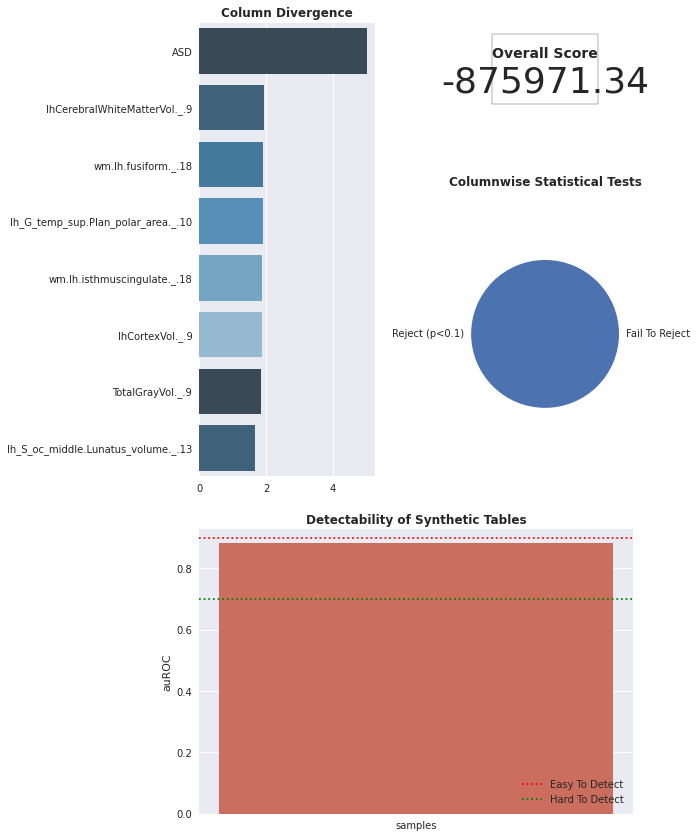

In [130]:
print(report.overall())
figure = report.visualize()

In [131]:
score_agg = []
score_agg.append(report.overall())
print(score_agg)

[-875971.3402337931]


In [132]:
#sns.lineplot(np.array(score_agg))
#plt.show

ValueError: Either both or neither of `x` and `y` must be specified (but try passing to `data`, which is more flexible).

## 6. Visualization of generated data

In [166]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

#dat_to_vis = df_augmented[features_forargu].values
#tsne = TSNE(n_componen ts=2)
#tsne_results = tsne.fit_transform(dat_to_vis)
tsne = TSNE(n_components=2, verbose=1, random_state=1234)
tsne_result = tsne.fit_transform(df_augmented)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6777 samples in 0.945s...
[t-SNE] Computed neighbors for 6777 samples in 65.905s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6777
[t-SNE] Computed conditional probabilities for sample 2000 / 6777
[t-SNE] Computed conditional probabilities for sample 3000 / 6777
[t-SNE] Computed conditional probabilities for sample 4000 / 6777
[t-SNE] Computed conditional probabilities for sample 5000 / 6777
[t-SNE] Computed conditional probabilities for sample 6000 / 6777
[t-SNE] Computed conditional probabilities for sample 6777 / 6777
[t-SNE] Mean sigma: 7.459000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.868980
[t-SNE] KL divergence after 1000 iterations: 1.545578


In [168]:
df_augmented['tsne-2d-one'] = tsne_results[:,0]
df_augmented['tsne-2d-two'] = tsne_results[:,1]

In [171]:
 tsne_results[:,0]

array([ 26.735195 , -44.819637 ,  10.4932165, ...,   4.8879924,
         8.833127 , -37.45092  ], dtype=float32)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


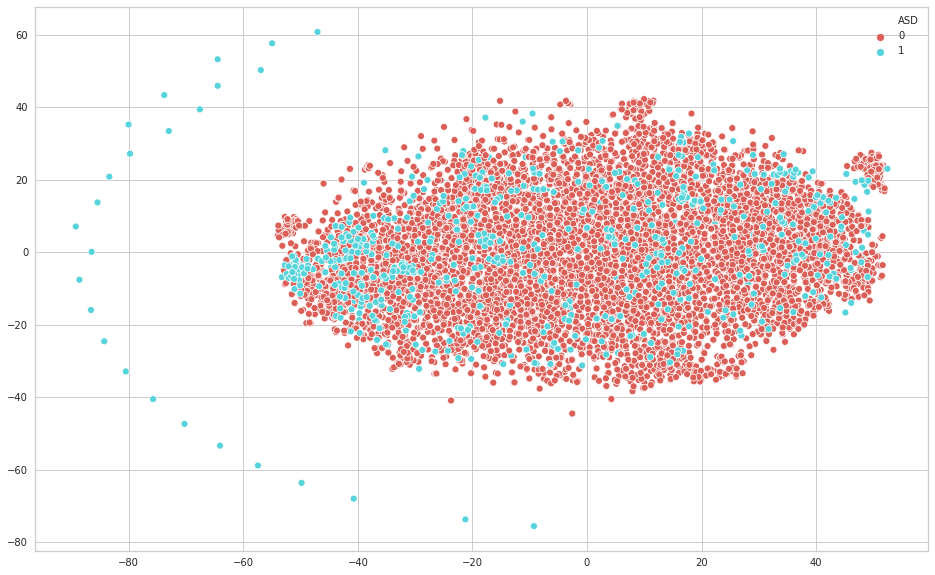

In [189]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1],
               hue=y,
               palette=sns.color_palette("hls", 2),
               data = df_augmented,
               legend = "full")